In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import urllib.request as req
from requests_html import HTMLSession
import time
import datetime as dt
from datetime import datetime
from datetime import date
import random
import time
import concurrent.futures
from urllib.parse import unquote, quote
import urllib

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import tqdm
# from tqdm import tqdm
import warnings
from google.colab import drive
drive.mount('/content/drive')
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100
InteractiveShell.ast_node_interactivity = "all"

Mounted at /content/drive


In [4]:
df = pd.read_excel("/content/drive/MyDrive/career/portfolio/web scrape/station_info.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   站號       635 non-null    object        
 1   站名       635 non-null    object        
 2   海拔高度(m)  635 non-null    float64       
 3   經度       635 non-null    float64       
 4   緯度       635 non-null    float64       
 5   城市       635 non-null    object        
 6   地址       635 non-null    object        
 7   資料起始日期   635 non-null    datetime64[ns]
 8   撤站日期     0 non-null      float64       
 9   備註       258 non-null    object        
 10  原站號      129 non-null    object        
 11  新站號      0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 59.7+ KB


In [21]:
station_list = []

start_date = "2023-01-01"
end_date = "2023-01-03"
datepicker_list = pd.date_range(start=start_date, end=end_date).strftime("%Y-%m-%d")

for i in range(len(df)):
  l = []
  station_id_query = str(df['站號'].iloc[i])
  station_name = df['站名'].iloc[i]
  station_name_query = quote(station_name)
  station_name_query = quote(station_name_query)
  station_att_query = str(df['海拔高度(m)'].iloc[i])+"m"
  station_list.append([station_id_query, station_name_query, station_att_query])

url_list = [[x, y] for x in station_list for y in datepicker_list]


urls = [f"https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station={i[0][0]}&stname={i[0][1]}&datepicker={i[1]}&altitude={i[0][2]}" for i in url_list]

def scrape(url):
  s = HTMLSession()
  USER_AGENT = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36"
  response = s.get(url, headers = {"User-Agents" : USER_AGENT})
  soup = BeautifulSoup(response.text, "html.parser")

  #setting delay second choice
  delay_choices = [2, 3]
  delay = random.choice(delay_choices)

  # imp = soup.find('label', attrs={"class": "imp"})

  row = soup.find_all('tr')
  row1 = row[0].find_all('td')

  station = str(row1[1].text)[3:].strip()
  record_date = str(row1[4].text)[5:].strip()

  for r in row[4:]:
    data = {}
    d = r.find_all('td')
    record_hour = int(d[0].text.strip())
    rain_mm = d[10].text.strip()

    data['record_date'] = record_date
    data['record_hour'] = record_hour
    data['station'] = station
    data['rain_mm'] = rain_mm

    data_main.append(data)

  time.sleep(delay)

In [22]:
data_main = []

In [23]:
start_time = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
  executor.map(scrape, urls)

end_time = time.time()

print(f"{end_time - start_time} seconds")

<generator object Executor.map.<locals>.result_iterator at 0x7b92e3e95e00>

240.19090795516968 seconds


In [24]:
# save the original raw data just for backup
df_main = pd.DataFrame(data_main)
df_main['record_date'].sort_values().unique()
df_main['station'] = df_main['station'].str.strip()
df_main['rain_mm'] = df_main['rain_mm'].str.strip()
df_main['record_date'] = df_main['record_date'].str.strip()

df_main.to_csv('weather_data_raw_'+start_date+'_'+end_date+'.csv', encoding = 'utf-8', index=False)

array(['2023-01-01', '2023-01-02', '2023-01-03'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14712 entries, 0 to 14711
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_date   14712 non-null  datetime64[ns]
 1   record_hour   14712 non-null  int64         
 2   station       14712 non-null  object        
 3   rain_mm       14219 non-null  float64       
 4   station_id    14712 non-null  object        
 5   station_name  14712 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 689.8+ KB


<Axes: >

record_date       0
record_hour       0
station           0
rain_mm         493
station_id        0
station_name      0
dtype: int64

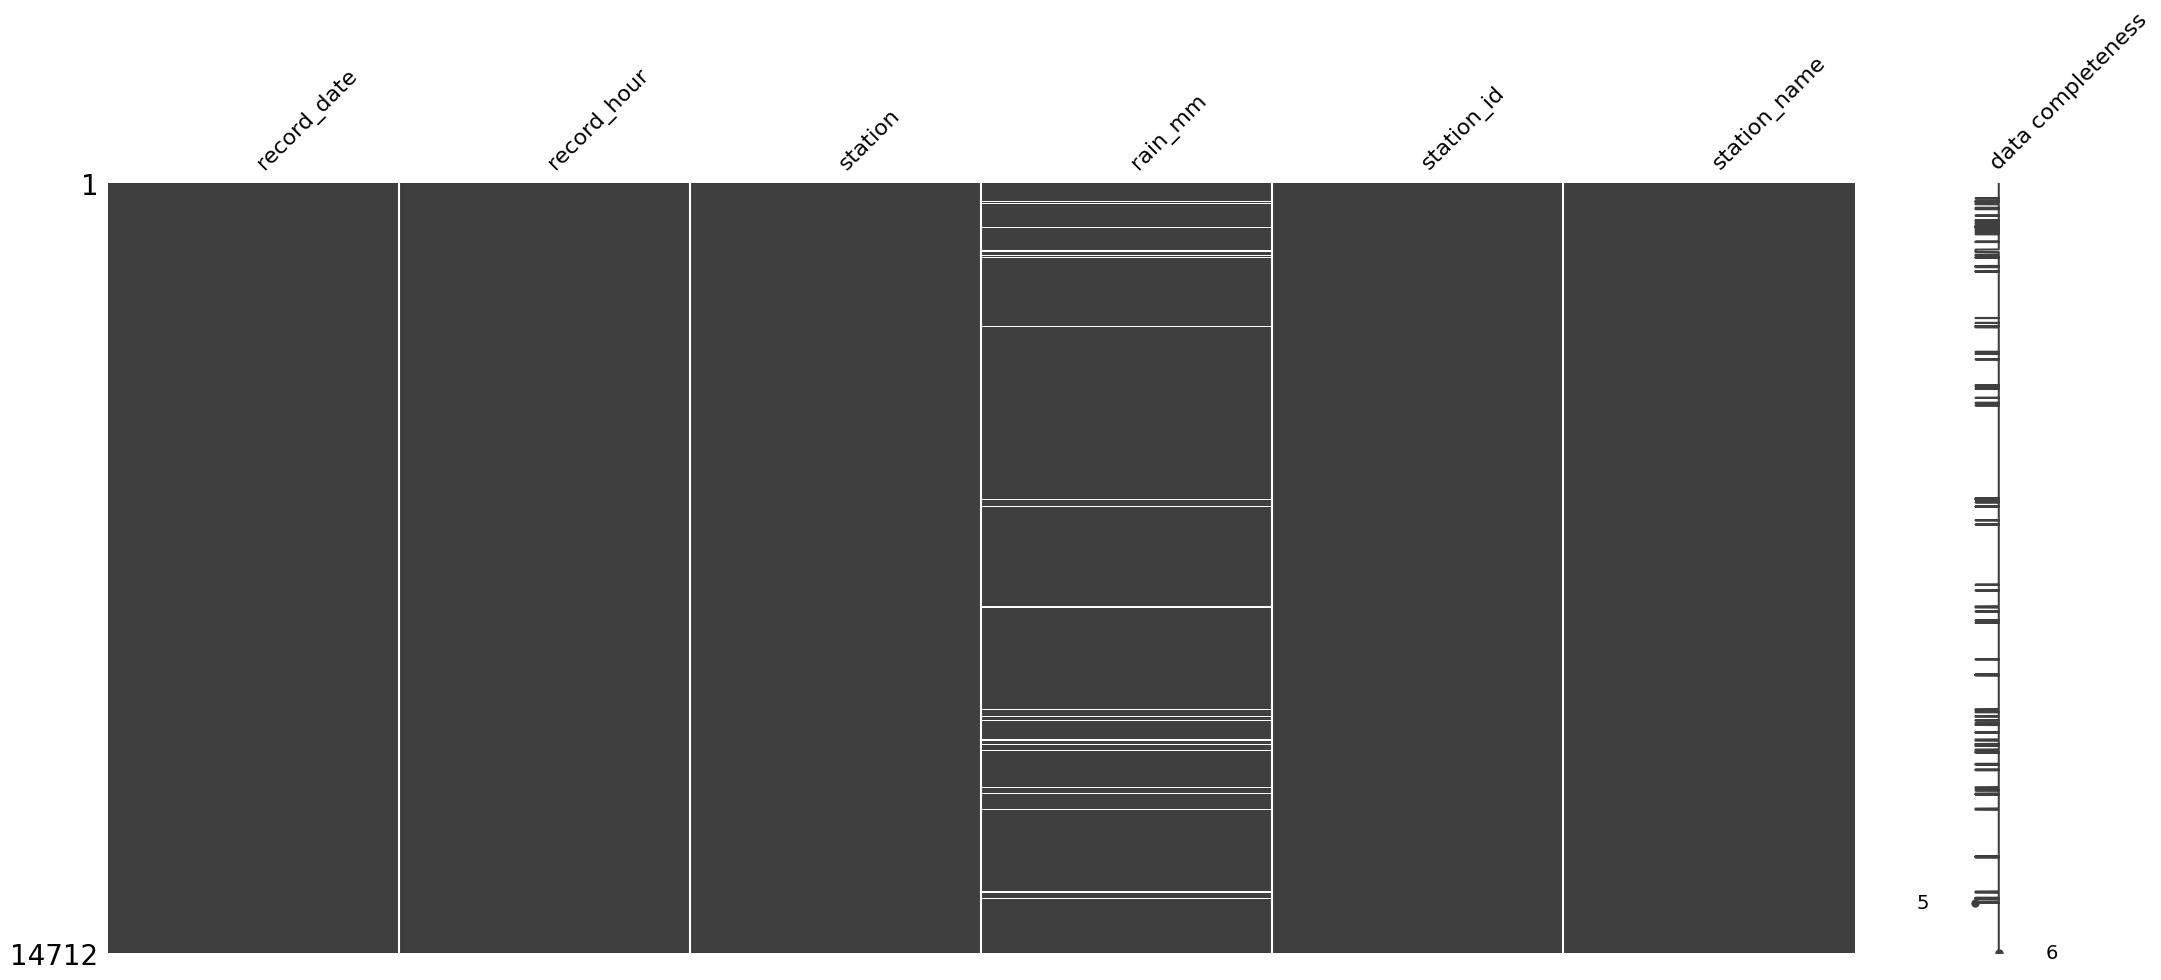

In [25]:
# clean rain_mm to float or null
# T: no rain; &, X, ... : not meaningful
df_main['rain_mm'].loc[df_main['rain_mm'] == 'T'] = '0'
df_main['rain_mm'].loc[df_main['rain_mm'] == '&'] = np.NaN  ##NaN
df_main['rain_mm'].loc[df_main['rain_mm'] == 'X'] = np.NaN  ##NaN
df_main['rain_mm'].loc[df_main['rain_mm'] == '...'] = np.NaN ##NaN

df_main['rain_mm'] = df_main['rain_mm'].astype(float)
df_main['record_date'] = pd.to_datetime(df_main['record_date'])

df_main['station_id'] = df_main['station'].str.split('_').str[0]
df_main['station_name'] = df_main['station'].str.split('_').str[1]

df_main.info()
msno.matrix(df_main, labels=True)
df_main.isnull().sum()
df_main.drop('station',axis=1, inplace = True)

df_main.to_csv('/content/drive/MyDrive/career/portfolio/web scrape/weather_data_clean_'+start_date+'_'+end_date+'.csv', encoding = 'utf-8', index=False)

# Missing Value

In [28]:
df_weather = pd.read_csv('/content/drive/MyDrive/career/portfolio/web scrape/weather_data_clean_'+start_date+'_'+end_date+'.csv', encoding = 'utf-8')
df_station = pd.read_csv('/content/drive/MyDrive/career/portfolio/web scrape/station_info_clean.csv')
df_city_clean = pd.read_csv('/content/drive/MyDrive/career/portfolio/web scrape/city_info.csv')

In [29]:
# merge weather data with its station district/city data and check missing proportion
df_weather['record_date'] = pd.to_datetime(df_weather['record_date'])
df_weather_w_info = df_weather.merge(df_station[['city_district', 'station_id']], left_on = 'station_id', right_on = 'station_id', how='left')
df_weather_w_info.isna().sum()
df_weather_w_info.sort_values(by=['record_date', 'record_hour'])

record_date        0
record_hour        0
rain_mm          493
station_id         0
station_name       0
city_district      0
dtype: int64

,record_date,record_hour,rain_mm,station_id,station_name,city_district
0,2023-01-01,1,0.0,467590,恆春,屏東縣恆春鎮
24,2023-01-01,1,0.0,467110,金門,金門縣金城鎮
96,2023-01-01,1,1.5,466930,竹子湖,臺北市北投區
120,2023-01-01,1,0.0,467420,永康,臺南市永康區
144,2023-01-01,1,0.0,467270,田中,彰化縣田中鎮
...,...,...,...,...,...,...
14471,2023-01-03,24,0.0,C1Z130,銅門,花蓮縣秀林鄉
14519,2023-01-03,24,0.0,C1Z040,立山,花蓮縣卓溪鄉
14615,2023-01-03,24,0.5,C1Z140,荖溪,花蓮縣秀林鄉
14639,2023-01-03,24,0.0,C1Z110,三棧,花蓮縣秀林鄉


In [30]:
# average rain_mm by city/district/date/hour
df_weather_w_info_summary = df_weather_w_info.groupby(['record_date', 'record_hour', 'city_district']).mean(np.mean).reset_index()
df_weather_w_info_summary.isna().sum()

df_weather_w_info_summary['is_valid'] = 1
df_weather_w_info_summary['is_valid'].loc[df_weather_w_info_summary['rain_mm'].isna()] = 0

df_weather_w_info_summary.describe()

record_date        0
record_hour        0
city_district      0
rain_mm          259
dtype: int64

,record_hour,rain_mm,is_valid
count,10104.000000,9845.000000,10104.000000
mean,12.500000,0.242824,0.974367
std,6.922529,0.782983,0.158047
min,1.000000,0.000000,0.000000
25%,6.750000,0.000000,1.000000
50%,12.500000,0.000000,1.000000
75%,18.250000,0.000000,1.000000
max,24.000000,16.250000,1.000000


In [31]:
# rain_mm: Fill in missing value with average of former and later hour rain_mm data. If both are NaN then return NaN
for index in tqdm.tqdm(df_weather_w_info_summary[df_weather_w_info_summary.rain_mm.isnull()].index):
  data = df_weather_w_info_summary.loc[index]
  before = np.nan
  after = np.nan
  # Find former and later hour rain_mm data
  if data.record_hour == 0:
    condition_before = ((df_weather_w_info_summary['record_date'] == (data['record_date']-dt.timedelta(days=1))) & (df_weather_w_info_summary['record_hour'] == 24) & (df_weather_w_info_summary['city_district']==data['city_district']))
    condition_after = ((df_weather_w_info_summary['record_date'] == data['record_date']) & (df_weather_w_info_summary['record_hour'] == 1) & (df_weather_w_info_summary['city_district']==data['city_district']))
    before = df_weather_w_info_summary[condition_before]['rain_mm']
    after = df_weather_w_info_summary[condition_after]['rain_mm']
  elif data.record_hour == 24:
    condition_before = ((df_weather_w_info_summary['record_date'] == data['record_date']) & (df_weather_w_info_summary['record_hour'] == 23) & (df_weather_w_info_summary['city_district']==data['city_district']))
    condition_after = ((df_weather_w_info_summary['record_date'] == (data['record_date'] + dt.timedelta(days=1))) & (df_weather_w_info_summary['record_hour'] == 0) & (df_weather_w_info_summary['city_district']==data['city_district']))
    before = df_weather_w_info_summary[condition_before]['rain_mm']
    after = df_weather_w_info_summary[condition_after]['rain_mm']
  else:
    condition_before = ((df_weather_w_info_summary['record_date'] == data['record_date']) & (df_weather_w_info_summary['record_hour'] == data['record_hour']-1) & (df_weather_w_info_summary['city_district']==data['city_district']))
    condition_after = ((df_weather_w_info_summary['record_date'] == data['record_date']) & (df_weather_w_info_summary['record_hour'] == data['record_hour']+1) & (df_weather_w_info_summary['city_district']==data['city_district']))
    before = df_weather_w_info_summary[condition_before]['rain_mm']
    after = df_weather_w_info_summary[condition_after]['rain_mm']


  result = np.mean([before, after])
  # print(before)
  df_weather_w_info_summary.loc[index, 'rain_mm'] = result

100%|██████████| 259/259 [00:01<00:00, 184.11it/s]


In [32]:
# check missing value after cleansing and save cleaned data
df_weather_w_info_summary['is_valid_new'] = 1
df_weather_w_info_summary['is_valid_new'].loc[df_weather_w_info_summary['rain_mm'].isna()] = 0
df_weather_w_info_summary.isnull().sum()
df_weather_w_info_summary.describe()
df_weather_w_info_summary.drop(['is_valid', 'is_valid_new'], axis=1).to_csv('weather_by_district_hour_clean_missing'+start_date+'_'+end_date+'.csv')

record_date        0
record_hour        0
city_district      0
rain_mm          228
is_valid           0
is_valid_new       0
dtype: int64

,record_hour,rain_mm,is_valid,is_valid_new
count,10104.000000,9876.000000,10104.000000,10104.000000
mean,12.500000,0.242492,0.974367,0.977435
std,6.922529,0.782220,0.158047,0.148520
min,1.000000,0.000000,0.000000,0.000000
25%,6.750000,0.000000,1.000000,1.000000
50%,12.500000,0.000000,1.000000,1.000000
75%,18.250000,0.000000,1.000000,1.000000
max,24.000000,16.250000,1.000000,1.000000


<Axes: xlabel='valid_hour_ratio', ylabel='Density'>

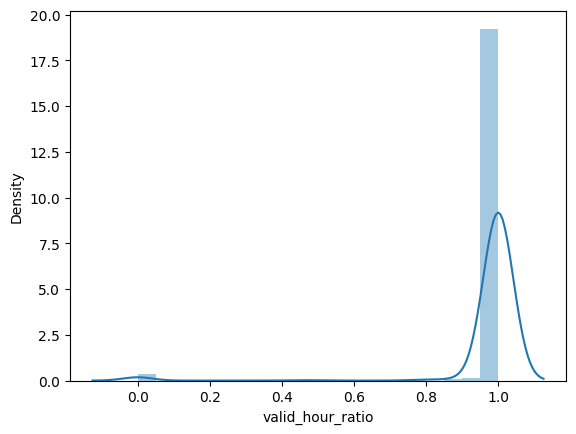

In [33]:
# check everyday valid hour ratio
# valid hour is the hour range that has valid rain_mm data

col = df_weather_w_info_summary['record_hour'].unique()
pv1_sum = pd.pivot_table(df_weather_w_info_summary, index=['city_district', 'record_date'], columns=['record_hour'], values=['is_valid_new'], aggfunc=['sum'])
pv1_sum.columns = col

pv1_sum_check_is_valid_new = pv1_sum.applymap(lambda x: 1 if x>0 else 0)
pv1_sum_check_is_valid_all_hour_new = pv1_sum_check_is_valid_new.sum(axis=1).reset_index().rename(columns = {0:'valid_hour'})
pv1_sum_check_is_valid_all_hour_new['valid_hour_ratio'] = pv1_sum_check_is_valid_all_hour_new['valid_hour']/len(col)

ranges = [-1, 0.5, 0.7, 0.99, 1, 2]
group_name = ['0~0.5', '0.5~0.7', '0.7~0.99', '1', '2']
pv1_sum_check_is_valid_all_hour_new['valid_ratio_range'] = pd.cut(pv1_sum_check_is_valid_all_hour_new.valid_hour_ratio, bins=ranges, labels=group_name)

pv2 = pd.pivot_table(pv1_sum_check_is_valid_all_hour_new, index=['city_district'], columns=['valid_ratio_range'], values=['record_date'], aggfunc = ['count'])
sns.distplot(pv1_sum_check_is_valid_all_hour_new['valid_hour_ratio'])
plt.show()

pv2.columns = ['0~0.5','0.5~0.7','0.7~0.99','1','2']
pv2 = pv2.drop('2', axis=1)
pv2['total'] = sum(pv2[i] for i in pv2.columns)
pv2.to_excel('city_value_valid_day_new'+start_date+'_'+end_date+'.xlsx')

<Axes: xlabel='valid_morning_ratio', ylabel='Density'>

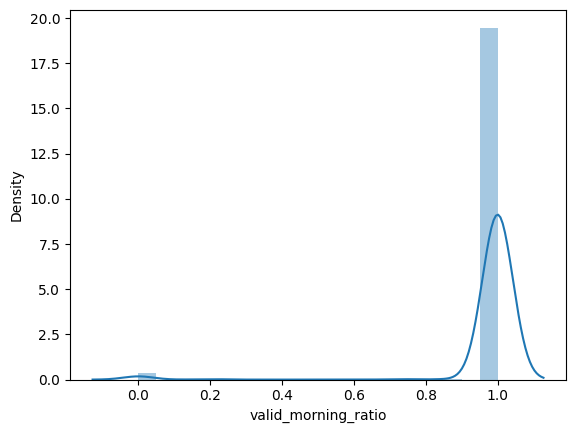

In [34]:
# check everyday morning hour valid ratio
# morning: 8~22
df_weather_w_info_summary['is_morning'] = 0
df_weather_w_info_summary['is_morning'].loc[(df_weather_w_info_summary['record_hour']>=8) & (df_weather_w_info_summary['record_hour']<=22)] = 1
df_weather_w_info_summary_morning_new = df_weather_w_info_summary.loc[df_weather_w_info_summary['is_morning']==1]

col2 = df_weather_w_info_summary_morning_new['record_hour'].unique()
pv3_sum_new = pd.pivot_table(df_weather_w_info_summary_morning_new, index=['city_district', 'record_date'], columns=['record_hour'], values=['is_valid_new'], aggfunc=['sum'])
pv3_sum_new.columns = col2

pv3_sum_check_is_valid_new = pv3_sum_new.applymap(lambda x: 1 if x>0 else 0)
pv3_sum_check_is_valid_morning_new = pv3_sum_check_is_valid_new.sum(axis=1).reset_index().rename(columns = {0:'valid_morning_hour'})
pv3_sum_check_is_valid_morning_new['valid_morning_ratio'] = pv3_sum_check_is_valid_morning_new['valid_morning_hour']/len(col2)

ranges = [-1, 0.5, 0.7, 0.99, 1, 2]
group_name = ['0~0.5', '0.5~0.7', '0.7~0.99', '1', '2']
pv3_sum_check_is_valid_morning_new['valid_morning_ratio_range'] = pd.cut(pv3_sum_check_is_valid_morning_new.valid_morning_ratio, bins=ranges, labels=group_name)

pv4 = pd.pivot_table(pv3_sum_check_is_valid_morning_new, index=['city_district'], columns=['valid_morning_ratio_range'], values=['record_date'], aggfunc = ['count'])
sns.distplot(pv3_sum_check_is_valid_morning_new['valid_morning_ratio'])
plt.show()

pv4.columns = ['0~0.5','0.5~0.7','0.7~0.99','1','2']
pv4 = pv4.drop('2', axis=1)
pv4['total'] = sum(pv4[i] for i in pv4.columns)
pv4.to_excel('city_value_valid_day_morning_new'+start_date+'_'+end_date+'.xlsx')